# Titanic Submission Notebook

In [1]:
#--------------------------IMPORTING LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
import numpy as np
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

data = pd.concat([train,test])
#  /(?:,.)(\w+)/  <-- selecting titles
# (?:,.)(\w+(.\w+)*).
#Extract Titles
data['Titles'] = data['Name'].str.extract('(?:,.)(\w+)', expand = False).str.strip()


Extracting Titles using RegEx and classifying them by class

In [3]:
Title_dict = {
    'Mr' : 'Mr',
    'Mlle' : 'Miss',
    'Miss' : 'Miss',
    'Mme' : 'Mrs',
    'Mrs' : 'Mrs',
    'Master' : 'Master',
    'Capt': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Dr': 'Officer',
    'Rev': 'Officer',
    'Don': 'Royalty',
    'Sir': 'Royalty',
    'the': 'Royalty',
    'Dona': 'Royalty',
    'Lady': 'Royalty',
    'Jonkheer': 'Royalty'
}

data['Titles'].replace(Title_dict, inplace = True)

In [4]:
#in test data..embarked has missing values..just fill S
data['Embarked'].fillna('S', inplace = True)
#print(data['Titles'].value_counts())
#print(data.groupby(['Sex','Pclass','Titles'])['Age'].median())
#Filling Age missing values
#print(data[data.index.duplicated()])
train = data[0:891].copy()
test = data[891:1309].copy()
train['Age'] = train.groupby(['Sex','Pclass','Titles'])['Age'].apply(lambda x: x.fillna(x.median()))
test['Age'] = test.groupby(['Sex','Pclass','Titles'])['Age'].apply(lambda x: x.fillna(x.median()))

In [5]:
#Fill Cabin missing values
#Not sure if needed..come back later
#Yes, it does matter apparently..
# train = train.drop('Cabin', axis = 1)
# test = test.drop('Cabin', axis = 1)
train.Cabin.fillna("Unknown", inplace = True)
test.Cabin.fillna("Unknown", inplace = True)
train['Cabin'] = train['Cabin'].map(lambda x: x[0])
test['Cabin'] = test['Cabin'].map(lambda x: x[0])
train.groupby(['Cabin']).mean()[train.groupby(['Cabin']).mean().columns[1:2]]

,Fare
Cabin,
A,39.623887
B,113.505764
C,100.151341
D,57.244576
E,46.026694
F,18.696792
G,13.581250
T,35.500000
U,19.157325


Do family sizes matter? Is preference given to people with families?

In [8]:
data['Family'] = data['Name'].str.extract('(.+\w+)(?:,)', expand = False).str.strip()
train['Family_size'] = train['SibSp'] + train['Parch']
test['Family_size'] = test['SibSp'] + test['Parch']
#plt.hist([data[data['Survived'] == 1]['Family_size'],data[data['Survived']==0]['Family_size']], color = ['g','r'], bins=15, label = ['Survived', 'Dead'])
#plt.xlabel('Family Size')
#plt.ylabel('Number of Passengers')
#plt.legend()
#plt.show()
def Family(x):
    if x == 1 or x==2:
        return 'little'
    elif x ==3:
        return 'medium'
    elif x >=4:
        return 'big'
    else:
        return 'single'

In [9]:
train['Family_size'] =train['Family_size'].apply(lambda x: Family(x))
test['Family_size'] = test['Family_size'].apply(lambda x: Family(x))
train = train.drop('Name', axis = 1)
test = test.drop('Name', axis = 1)
(train.groupby(['Pclass', 'Family_size'])['Survived'].mean())

Pclass  Family_size
1       big            0.666667
        little         0.734043
        medium         0.714286
        single         0.532110
2       big            1.000000
        little         0.600000
        medium         0.769231
        single         0.346154
3       big            0.074074
        little         0.384615
        medium         0.666667
        single         0.212963
Name: Survived, dtype: float64

In [10]:
def Ticket_Prefix(x):
    l=x.split()
    if len(x.split()) == 3:
        return x.split()[0] + x.split()[1]
    elif len(x.split()) == 2:
        return x.split()[0]
    else:
        return 'None'
train['TicketPrefix'] = train['Ticket'].apply(lambda x: Ticket_Prefix(x))
test['TicketPrefix'] = test['Ticket'].apply(lambda x: Ticket_Prefix(x))

In [11]:
test['Fare'] = test.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median()))
train = train.drop('Ticket', axis = 1)
test = test.drop('Ticket', axis = 1)
drop = ['SibSp', 'Parch']
for i in drop:
    train.drop([i],axis = 1, inplace = True)
    test.drop([i],axis = 1, inplace = True)


Yes..singles died the most :( // medium family sizes are most beneficial..till 3

How much does Gender affect Survival?

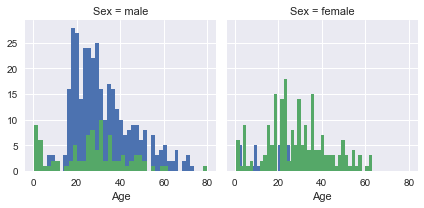

In [12]:
g = sns.FacetGrid(data, col="Sex", hue="Survived", hue_order=[0,1], legend_out=True)
g = g.map(plt.hist, "Age", bins = 40)
#plt.show()
data['Child'] = ((data['Age']) < 18 )
data['Mother'] = ((data['Sex'] == 'female') & (data['Age'] >= 18) & (data['Parch']  > 0))


Evidently the female survival ratio was much better than the males, as the women and children get evacuated first.

Now going back
We need to process the data

In [13]:
#Male:0, Female:1
# data['Sex'] = data['Sex'].map({"male" : 0, "female" : 1})
# data['Embarked'] = data['Embarked'].map({'S': 0 , 'C': 1 , 'Q': 2})
# data['Titles'] = data['Titles'].map({'Officer' : 0, 'Master' : 1, 'Ms' : 2, 'Royalty' : 3, 'Miss' : 4, 'Mr' : 5, 'Mrs' : 6})
#^ this is wrong..better to create dummies

for i in train.columns:
    if train[i].dtype == 'object' or i == 'Pclass':
        dummies = pd.get_dummies(train[i], drop_first=False)
        dummies = dummies.add_prefix('{}_'.format(i))
        train.drop(i, axis = 1,inplace = True)
        train = train.join(dummies)

In [14]:
for i in test.columns:
    if test[i].dtype == 'object' or i == 'Pclass':
        dummies = pd.get_dummies(test[i], drop_first=False)
        dummies = dummies.add_prefix('{}_'.format(i))
        test.drop(i, axis=1, inplace=True)
        test = test.join(dummies)

test['Age'].fillna(15,inplace = True)
X_train = train.drop('Survived', axis = 1)
Y_train = train['Survived']
X_test =  test

Trying out a RandomForest Classifir

In [15]:
model = RandomForestClassifier(n_estimators= 15,max_features='sqrt',criterion='gini', min_samples_split=7,min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 18, max_depth=None)
model.fit(X_train, Y_train)
index = np.argsort(model.feature_importances_)[::-1]
# # print(index)
# print('Feature ranking:')
# for f in range(X_train.shape[1]):
#     print('%d. feature %d %s (%f)' % (f + 1, index[f], X_train.columns[index[f]], model.feature_importances_[index[f]]))


In [17]:
model = SelectFromModel(model, prefit=True)
X_new = model.transform(X_train)
print(X_new.shape)
best_features = X_train.columns[index[0:X_new.shape[1]]]
X = X_train[best_features]
Xt = X_test[best_features]
print(best_features)
plt.figure(figsize=(15,15))

X_train, X_test, y_train, y_test = train_test_split(X, Y_train, test_size=0.33, random_state=44)

ValueError: The underlying estimator SelectFromModel has no `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to SelectFromModel or call fit before calling transform.

Using Hyperparameter Tuning

ValueError: min_samples_split must be at least 2 or in (0, 1], got 1

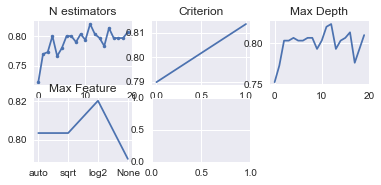

In [18]:
#N estimators
plt.subplot(331)
feature_param = range(1,21)
scores = []
for feature in feature_param:
    clf = RandomForestClassifier(n_estimators=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores,'.-')
plt.axis('tight')
plt.title('N estimators')

#Criterion
plt.subplot(332)
feature_param = ['gini', 'entropy']
scores = []
for feature in feature_param:
    clf = RandomForestClassifier(criterion=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores)
plt.axis('tight')
plt.title('Criterion')

#Max Depth
plt.subplot(333)
feature_param = range(1,21)
scores = []
for feature in feature_param:
    clf = RandomForestClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores)
plt.axis('tight')
plt.title('Max Depth')

#Max Features
plt.subplot(334)
feature_param = ['auto','sqrt','log2',None]
scores = []
for feature in feature_param:
    clf = RandomForestClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores)
plt.axis('tight')
plt.xticks(range(len(feature_param)), feature_param)
plt.title('Max Feature')

#Min Sample Split
plt.subplot(3,3,5)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Min Samples Split')

plt.subplot(3,3,6)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Min Weight Fraction Leaf')


#Max Leaf Nodes
plt.subplot(3,3,7)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Max Leaf Nodes')
plt.grid();

plt.show()


In [19]:
#Hyper Parameter Tuning
# forest = RandomForestClassifier(max_depth=50, min_samples_split=7,
#                                 min_weight_fraction_leaf=0.0,
#                                 max_leaf_nodes = 18)
#
# param_grid = {'n_estimators': [15,100,200],
#               'criterion': ['gini','entropy'],
#               'max_features': ['auto','sqrt','log2', None]}
# grid_search = GridSearchCV(forest, param_grid=param_grid, cv = StratifiedKFold(5))
# grid_search.fit(X, Y_train)
# print('Best Score: {}'.format(grid_search.best_score_))
# print('Best Parameters: {}'.format(grid_search.best_params_))
#
# forest = RandomForestClassifier(n_estimators=200,
#                                 criterion='entropy',
#                                 max_features=None)
# param_grid = {
#     'max_depth': [None,50],
#     'min_samples_split' : [7,11],
#     'min_weight_fraction_leaf' : [0.0,0.2],
#     'max_leaf_nodes' : [18,20]}
# grid_search = GridSearchCV(forest,param_grid=param_grid, cv=StratifiedKFold(5))
# grid_search.fit(X,Y_train)
# print('Best Score: {}'.format(grid_search.best_score_))
# print('Best Parameters: {}'.format(grid_search.best_params_))

clf = RandomForestClassifier(n_estimators = 200,
                                criterion = 'entropy',
                                max_features = None,
                                max_depth = 50,
                                min_samples_split =7,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 18)
print(Xt.isnull().any())
# #Fit model
clf.fit(X, Y_train)
Y_pred_RF = clf.predict(Xt)
 #Show validation accuracy
print(clf.score(X_test,y_test))

# y_test= model.predict(X_test)
# #print(y_test)

#Write prediction to the file.
submission = pd.DataFrame({
        'PassengerId': test['PassengerId'],
        'Survived': (Y_pred_RF)
    })
submission.to_csv('titanic.csv', index=False)

Sex_male              False
Titles_Mr             False
Fare                  False
Sex_female            False
Pclass_3              False
Age                   False
Titles_Mrs            False
PassengerId           False
Cabin_U               False
Pclass_1              False
Family_size_big       False
Family_size_little    False
Titles_Miss           False
Titles_Master         False
dtype: bool
0.864406779661
